In [3]:
CLR = {
    'blue': ['#e0f3ff', '#aadeff', '#2bb1ff', '#15587f', '#0b2c40'],
    'gold': ['#fff3dc', '#ffebc7', '#ffddab', '#b59d79', '#5C4938'],
    'red':  ['#ffd8e8', '#ff9db6', '#ff3e72', '#6B404C', '#521424'],
    'gray': ['#eeeeee', '#bbbbbb', '#999999', '#666666', '#333333'],
}

# Preselect-Dataset Experiments

In [13]:
from ungol.retrieval.stats import ExperimentStats

import attr
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
import matplotlib.patches as ppt
from tqdm import tqdm_notebook as tqdm

import pickle
import pathlib
from collections import defaultdict

from typing import List
from typing import Dict

In [14]:
# e.g. .../ungol_180921.750.1_rhwmd.adaptive-big.pickle

folder = pathlib.Path('../opt/frozen/09-baseline')

In [15]:
def listdict():
    return defaultdict(list)

@attr.s
class Result:
    
    # e.g. 'rhwmd.adaptive-small'
    fn: str = attr.ib()  
    # size -> ExperimentStats collection
    runs: Dict[int, List[ExperimentStats]] = attr.ib(default=attr.Factory(listdict))
        
    def mean_avg_prec(self, k: int):
        maps = [exp.mean_avg_precision for exp in self.runs[k]]
        return sum(maps) / len(maps)

out_dir = pathlib.Path('opt/')

def _fig_before(title: str, xlabel: str, ylabel: str):
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        return fig, ax

def _fig_after(fig, ax, patches=None, fname=None):
    if patches:
        ax.legend(handles=patches)
    
    if display:
        plt.show(fig)
    if fname:
        for out_file in [str(out_dir/fname) + s for s in ('.png', '.svg')]:
            print('saving to', out_file)
            fig.savefig(out_file)

    plt.close(fig)

In [22]:
results: Dict[str, Result] = dict()
translate = {
    'rhwmd.adaptive-big': 'rhwmd.big',
    'rhwmd.adaptive-small': 'rhwmd.small',
    'bm25.max': 'bm25',
    'tfidf.max': 'tfidf',
    'relaxed': 'wmd', }

globs = [glob for glob in folder.glob('*.pickle')]
for glob in tqdm(globs):
    try:
        _, serial, fn = glob.stem.split('_')  # e.g. 'ungol', '180921.250.3', 'rhwmd.adaptive-small'
        date, size, run = serial.split('.')   # e.g. '180921', '250', '3'
    except ValueError:
        print(str(glob))
        break
        
    size = int(size)
    
    if fn in translate:
        fn = translate[fn]
    
    if fn not in results:
        results[fn] = Result(fn=fn)
    
    with glob.open('rb') as fd:
        exp = pickle.load(fd)
    
    results[fn].runs[size].append(exp)
    
print('done')


done


In [36]:
print(results['rhwmd.small'].runs[250][0].mean_avg_precision)
print(results['rhwmd.small'].mean_avg_prec(250))

for key in results:
    print(key)
    stds = []
    
    for run in results[key].runs:
        a = np.array([x.mean_avg_precision for x in results[key].runs[run]])
        # print('  ', run, a.std())
        stds.append(a.std())
        
    print('  ', np.array(stds).mean())

0.9347380917981482
0.9409583261186169
rhwmd.small
   0.006632443073283841
rhwmd.max
   0.006619520910365396
bm25
   0.00466672479623293
rhwmd.min
   0.004696855645556684
rhwmd.big
   0.004936528881646662
tfidf
   0.0044924517603125705
rhwmd.sum
   0.006862707848698848
wmd
   0.0021401306893110237


In [23]:
# simplify data and re-build col-wise

# mapping data
cols = []
rows = []

# holding data
data = defaultdict(dict)

for kind in results:
    if kind not in rows:
        rows.append(kind)
    
    for run in results[kind].runs:
        if run not in cols:
            cols.append(run)
            
        data[kind][run] = results[kind].mean_avg_prec(run)

# row major
cols.sort()
rows = np.array(rows)

a_data = np.array([[data[row].get(col, 0) for col in cols] for row in rows])        
np.set_printoptions(precision=2)

# sort by row mean
order = np.argsort(a_data.mean(axis=1))

print('\nrows')
for row in rows[order]:
    print(f'{row:20s} & ')

print('\ncols')
print(repr(cols))

print('\ndata')

print(repr(a_data[order] * 100))


rows
wmd                  & 
rhwmd.big            & 
rhwmd.min            & 
tfidf                & 
rhwmd.max            & 
rhwmd.small          & 
bm25                 & 
rhwmd.sum            & 

cols
[250, 500, 750, 1000, 2000, 5000, 10000, 20000, 50000, 100000]

data
array([[69.62, 63.85, 59.98, 56.84, 50.01, 41.09, 35.05, 28.13, 20.94,
        15.06],
       [76.76, 67.8 , 62.9 , 59.46, 51.53, 40.47, 32.91, 25.3 , 18.  ,
        12.45],
       [77.75, 68.96, 64.1 , 60.44, 52.89, 42.17, 35.07, 26.98, 19.98,
        13.91],
       [84.12, 76.41, 73.59, 70.02, 60.95, 50.4 , 41.16, 32.88, 22.88,
        16.33],
       [94.1 , 90.54, 88.61, 86.45, 81.68, 73.22, 66.41, 59.74, 50.59,
        42.87],
       [94.1 , 90.54, 88.61, 86.45, 81.68, 73.22, 66.41, 59.73, 50.62,
        42.9 ],
       [93.07, 89.99, 88.38, 86.69, 82.84, 76.36, 70.64, 65.  , 56.94,
        51.02],
       [96.03, 93.44, 91.8 , 90.27, 85.82, 78.91, 72.8 , 66.62, 57.49,
        49.82]])


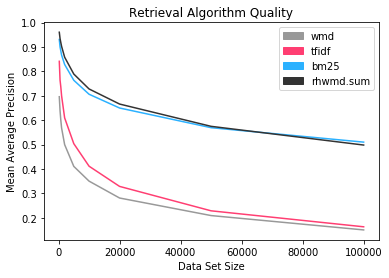

saving to opt/rhwmd-exp-preselection-plot.png
saving to opt/rhwmd-exp-preselection-plot.svg


In [24]:
plot_selection = ['wmd', 'tfidf', 'bm25', 'rhwmd.sum']
colors = [CLR['gray'][2], CLR['red'][2], CLR['blue'][2], CLR['gray'][4]]

a_data = np.array([[data[row].get(col, 0) for col in cols] for row in plot_selection])
fig, ax = _fig_before('Retrieval Algorithm Quality', 'Data Set Size', 'Mean Average Precision')

patches = []
for i, row in enumerate(a_data):
    patches.append(ppt.Patch(color=colors[i], label=plot_selection[i]))
    ax.plot(cols, row, color=colors[i])

_fig_after(fig, ax, patches=patches, fname='rhwmd-exp-preselection-plot')

## Retrieval Time

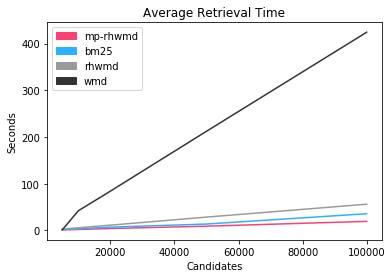

saving to opt/time-benchmark.png
saving to opt/time-benchmark.svg


In [45]:
# Because of my Alzheimers, the timedelta attribute was not set for the experiments
# Thus all this data was collected by hand :(
# print(results['rhwmd.small'].runs[250][0].stats['141-AH'].timedelta) -> None

data = [
    # 5_000
    1, 1.68, 2.76, 2.99, 2.72, 2.75, 2.77,
    1, 1.62, 2.77, 2.75, 2.78, 2.75, 2.81,
    1, 1.63, 2.76, 2.76, 2.74, 2.78, 2.83,
    # 10_000
    2, 3.31, 5.48, 5.54, 5.50, 5.54, 5.54,
    2, 3.33, 5.53, 5.53, 5.49, 5.62, 5.64,
    2, 3.37, 5.56, 5.58, 5.59, 5.55, 5.57,
    # 20_000
    4, 7.03, 11.20, 11.14, 10.92, 11.01, 11.06,
    4, 6.60, 11.01, 11.82, 11.36, 11.03, 11.19,
    4, 7.22, 11.15, 10.98, 11.89, 11.07, 10.98,
    # 50_000
    9, 16.80, 28.68, 27.76, 28.00, 29.57, 28.20,
    9, 6.92, 28.48, 27.71, 28.53, 28.08, 28.87,
    9, 17.00, 27.80, 28.62, 28.67, 30.42, 27.39,
    # 100_000
    19.3, 34.71, 59.84, 55.75, 55.02, 55.20, 55.00,
    19.3, 38.11, 56.77, 54.72, 54.83, 54.98, 56.80,
    19.3, 34.16, 59.65, 55.78, 55.43, 54.95, 56.23,
]

cols = []
rows = []

def transl(s: str):
    conf, name = s.split('_')                  # 5000.2_rhwmd.max
    k, it = (int(i) for i in conf.split('.'))  # 5000.2
    
    if name in translate:
        name = translate[name]
    
    if name.startswith('rhwmd'):
        name = 'rhwmd'
    
    if name not in rows:
        rows.append(name)
    
    if k not in cols:
        cols.append(k)
    
    return name, k

runs = [transl(s) for s in (
    "5000.1_mp-rhwmd", "5000.1_bm25.max", "5000.1_rhwmd.min",
    "5000.1_rhwmd.max", "5000.1_rhwmd.adaptive-small",
    "5000.1_rhwmd.adaptive-big", "5000.1_rhwmd.sum",
    "5000.2_mp-rhwmd", "5000.2_bm25.max", "5000.2_rhwmd.min",
    "5000.2_rhwmd.max", "5000.2_rhwmd.adaptive-small",
    "5000.2_rhwmd.adaptive-big", "5000.2_rhwmd.sum",
    "5000.3_mp-rhwmd", "5000.3_bm25.max", "5000.3_rhwmd.min",
    "5000.3_rhwmd.max", "5000.3_rhwmd.adaptive-small",
    "5000.3_rhwmd.adaptive-big", "5000.3_rhwmd.sum",
    "10000.1_mp-rhwmd", "10000.1_bm25.max", "10000.1_rhwmd.min",
    "10000.1_rhwmd.max", "10000.1_rhwmd.adaptive-small",
    "10000.1_rhwmd.adaptive-big", "10000.1_rhwmd.sum",
    "10000.2_mp-rhwmd", "10000.2_bm25.max", "10000.2_rhwmd.min",
    "10000.2_rhwmd.max", "10000.2_rhwmd.adaptive-small",
    "10000.2_rhwmd.adaptive-big", "10000.2_rhwmd.sum",
    "10000.3_mp-rhwmd", "10000.3_bm25.max", "10000.3_rhwmd.min",
    "10000.3_rhwmd.max", "10000.3_rhwmd.adaptive-small",
    "10000.3_rhwmd.adaptive-big", "10000.3_rhwmd.sum",
    "20000.1_mp-rhwmd", "20000.1_bm25.max", "20000.1_rhwmd.min",
    "20000.1_rhwmd.max", "20000.1_rhwmd.adaptive-small",
    "20000.1_rhwmd.adaptive-big", "20000.1_rhwmd.sum",
    "20000.2_mp-rhwmd", "20000.2_bm25.max", "20000.2_rhwmd.min",
    "20000.2_rhwmd.max", "20000.2_rhwmd.adaptive-small",
    "20000.2_rhwmd.adaptive-big", "20000.2_rhwmd.sum",
    "20000.3_mp-rhwmd", "20000.3_bm25.max", "20000.3_rhwmd.min",
    "20000.3_rhwmd.max", "20000.3_rhwmd.adaptive-small",
    "20000.3_rhwmd.adaptive-big", "20000.3_rhwmd.sum",
    "50000.1_mp-rhwmd", "50000.1_bm25.max", "50000.1_rhwmd.min",
    "50000.1_rhwmd.max", "50000.1_rhwmd.adaptive-small",
    "50000.1_rhwmd.adaptive-big", "50000.1_rhwmd.sum",
    "50000.2_mp-rhwmd", "50000.2_bm25.max", "50000.2_rhwmd.min",
    "50000.2_rhwmd.max", "50000.2_rhwmd.adaptive-small",
    "50000.2_rhwmd.adaptive-big", "50000.2_rhwmd.sum",
    "50000.3_mp-rhwmd", "50000.3_bm25.max", "50000.3_rhwmd.min",
    "50000.3_rhwmd.max", "50000.3_rhwmd.adaptive-small",
    "50000.3_rhwmd.adaptive-big", "50000.3_rhwmd.sum",
    "100000.1_mp-rhwmd", "100000.1_bm25.max", "100000.1_rhwmd.min",
    "100000.1_rhwmd.max", "100000.1_rhwmd.adaptive-small",
    "100000.1_rhwmd.adaptive-big", "100000.1_rhwmd.sum",
    "100000.2_mp-rhwmd", "100000.2_bm25.max", "100000.2_rhwmd.min",
    "100000.2_rhwmd.max", "100000.2_rhwmd.adaptive-small",
    "100000.2_rhwmd.adaptive-big", "100000.2_rhwmd.sum",
    "100000.3_mp-rhwmd", "100000.3_bm25.max", "100000.3_rhwmd.min",
    "100000.3_rhwmd.max", "100000.3_rhwmd.adaptive-small",
    "100000.3_rhwmd.adaptive-big", "100000.3_rhwmd.sum" )]

assert len(data) == len(runs)


times = defaultdict(dict)
for (name, k), time in zip(runs, data):
    lis = times[name].get(k, [])
    lis.append(time)
    times[name][k] = lis

data = [(row, [(k, np.array(times[row][k]).mean()) for k in cols]) for row in rows]
colors = CLR['red'][2], CLR['blue'][2], CLR['gray'][2], CLR['gray'][4]
patches = []

# additional manually inserted data :(

data.append(['wmd', [(5000, 1.14), (10000, 42), (20000, 84,7), (50000, 212.2), (100000, 424.3)]])

# ---

fig, ax = _fig_before('Average Retrieval Time', 'Candidates', 'Seconds')
# ax.set_yscale('log')
for i, (kind, items) in enumerate(data):
    patches.append(ppt.Patch(color=colors[i], label=kind))
    x, y = zip(*items)
    ax.plot(x, y, color=colors[i])
    
_fig_after(fig, ax, patches=patches, fname='time-benchmark')